In [279]:
# to get the generes and songs json files location
import os
import random
import json
import math
import matplotlib.pyplot as plt


cwd = os.getcwd()
cwd += "/song_db"


def get_genere_dict(path):
    
    json_files = os.listdir(path)
    genere_dict = {}
    
    for file in json_files:
        file_path = f"{path}/{file}"
        genere = file.split(".")[0]
        with open(file_path) as fp:
            genere_dict[genere] = json.load(fp)
        
    return genere_dict

In [280]:
# get the generes dictionary and the list of geners
genere_dict = get_genere_dict(cwd)
generes = list(genere_dict.keys())
# select number of generes you want 
num_of_gens = 3
selected_generes = random.sample(generes, num_of_gens)
# get all songs form those generes
songs = {}

for genere in selected_generes:
    songs.update(genere_dict[genere])

print(f"The selected generes are {selected_generes}")

The selected generes are ['black-metal', 'club', 'country']


In [281]:
#Constants for SA algorithm

desired_values = {
    'length': 3600,
    'energy': 70,
    'valence': 60,
    'pop': 90
}

NUM_SONGS = round(desired_values["length"]/180)  # Number of songs of the playlist

In [282]:
def calculate_fitness(solution, desired_values, songs, weights = {"energy_weight": 1.0, "valence_weight": 1.0, "popularity_weight": 1.0, "length_weight": 1.0}):
    total_diff = 0

    # Weights
    energy_weight = weights["energy_weight"]
    valence_weight = weights["valence_weight"]
    popularity_weight = weights["popularity_weight"]
    length_weight = weights["length_weight"]
    exceed_length_penalty = 20  # penalty if playlist length exceeds the desired length

    min_length = min([songs[song]['length'] for song in songs])
    max_length = max([songs[song]['length'] for song in songs])
    song_lengths = [songs[song]['length'] for song in solution]
    normalized_lengths = [(x - min_length) / (max_length - min_length) for x in song_lengths]
    normalized_desirelen = (desired_values["length"] - min_length) / (max_length - min_length)
    
    for song_id in solution:
        song = songs[song_id]
        
        # Normalized differences.
        energy_diff = abs((song['energy']/100) - (desired_values['energy']/100))
        valence_diff = abs((song['valence']/100) - (desired_values['valence']/100))
        popularity_diff = abs((song['pop']/100) - (desired_values['pop']/100))

        # Weighted sum of differences
        total_diff += (energy_weight * energy_diff) + (valence_weight * valence_diff) + (popularity_weight * popularity_diff)
    length_diff = abs(sum(normalized_lengths) - normalized_desirelen)
    total_diff += length_weight * length_diff

    return total_diff


In [283]:
def generate_neighbor(current_playlist, songs, desired_values):
    new_playlist = current_playlist.copy()
    song_ids = list(songs.keys())

    # Insertion or deletion if playlist is too short or too long
    current_length = sum(songs[song_id]['length'] for song_id in new_playlist)
    if current_length < desired_values['length']-60: # -60 for the flexibility.
        # Insert a new song
        new_song = random.choice(song_ids)
        while new_song in new_playlist:
            new_song = random.choice(song_ids)
        new_playlist.append(new_song)
    elif current_length > desired_values['length']+60: # +60 is there for flexibility
        # Delete a random song
        new_playlist.remove(random.choice(new_playlist))
    else:
        # Swap two songs for random ones
        idx1, idx2 = random.sample(range(len(new_playlist)), 2)
        additions = random.sample(song_ids, 2)
        while additions[0] in new_playlist or additions[1] in new_playlist:
            additions = random.sample(song_ids, 2)
        new_playlist[idx1], new_playlist[idx2] = additions[0], additions[1]

    return new_playlist


In [284]:
def simulated_annealing(songs, initial_temperature, cooling_rate):
    # Initialize the playlist with random songs
    current_playlist = random.sample(list(songs.keys()), NUM_SONGS)
    current_fitness = calculate_fitness(current_playlist, desired_values,songs)
    fitness = [current_fitness]
    temperature = initial_temperature

    while temperature > 1:
        new_playlist = generate_neighbor(current_playlist, songs, desired_values)
        new_fitness = calculate_fitness(new_playlist, desired_values, songs)
        fitness.append(new_fitness)

        # If the new playlist is better, accept it
        # If not, accept it with a certain probability
        if new_fitness < current_fitness or random.uniform(0, 1) < math.exp((current_fitness - new_fitness) / temperature):
            current_playlist = new_playlist
            current_fitness = new_fitness

        temperature *= cooling_rate

    return current_playlist, fitness


In [285]:
algo = simulated_annealing(songs, initial_temperature=1000, cooling_rate=0.98)
best_playlist = algo[0]
fitness_scores = algo[1]
print(best_playlist)
print(calculate_fitness(best_playlist,desired_values,songs))

['A New Error', 'Hey Boy Hey Girl', 'Show Me Love', 'Never Say Never', 'Crash and Burn', 'Wasted Love (feat. Dougy)', 'The Fireman', 'Animals - Extended', "It's A Great Day To Be Alive", 'Greyhound', 'Temptation', 'What Kinda Gone', 'Loving You Easy', 'Alright']
11.760248484848487


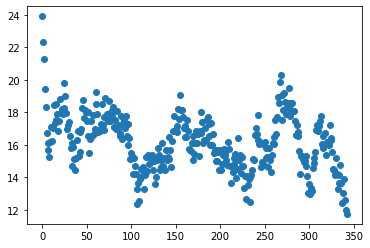

In [286]:
plt.scatter(list(range(len(fitness_scores))), fitness_scores)